# **Music recommender systems can suggest songs to users based on their listening patterns**

## **Import Libraries**

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import *
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## **Import data sets**

In [2]:
train = pd.read_csv('E:\\INTERNSHIP TASK\\train.csv')
test = pd.read_csv('E:\\INTERNSHIP TASK\\test.csv')
songs = pd.read_csv('E:\\INTERNSHIP TASK\\songs.csv')
extra_song = pd.read_csv('E:\\INTERNSHIP TASK\\song_extra_info.csv')

## **Exploratory Data Analysis**

### 1. Train Data Exploration

In [3]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


**1.1 let us check if the data is balanced**

In [4]:
np.mean(train.target)

0.5035170841614234

**1.2 let us check if we have missing values**

In [5]:
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

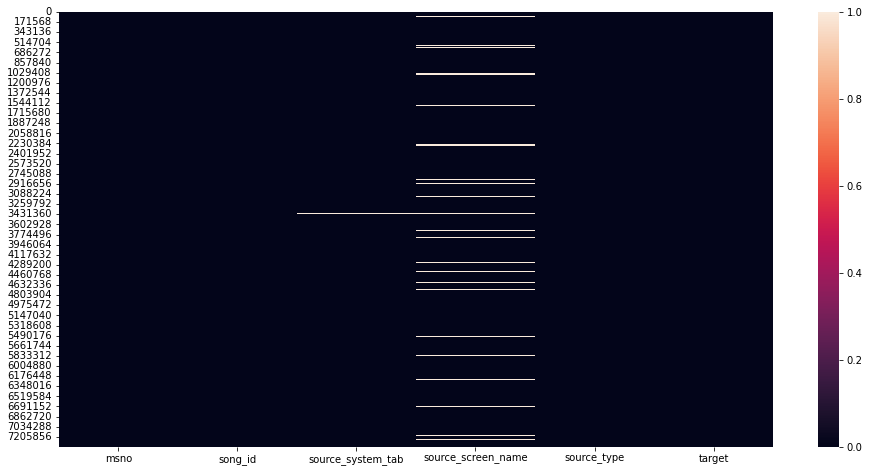

In [6]:
plt.figure(figsize = (16,8))
sns.heatmap(train.isnull())
plt.show()

**1.3 let us check the distirbution of categorical variables**

In [7]:
a = train.groupby('source_system_tab').size()
a = pd.DataFrame(a)
a.reset_index(level = 0, inplace = True)
a.columns = ['Source System Tab','Count']
a = a.sort_values(by = 'Count', ascending = False)
print(a)

  Source System Tab    Count
3        my library  3684730
0          discover  2179252
6            search   623286
5             radio   476701
2       listen with   212266
1           explore   167949
4      notification     6185
7          settings     2200


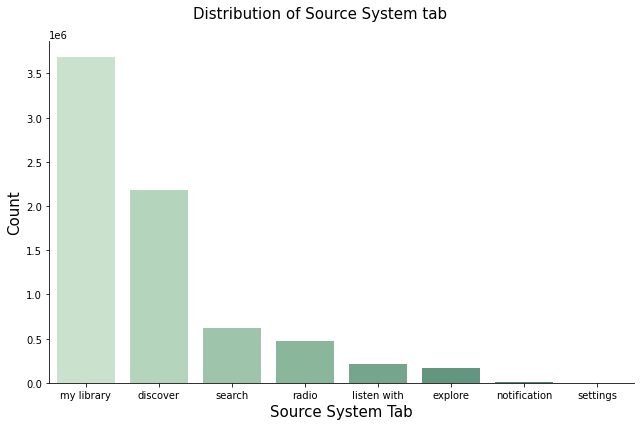

In [8]:
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x = 'Source System Tab', y = 'Count', kind = 'bar',
                data = a, height = 6, palette = 'ch:2.5,-.2,dark =.4',
                aspect = 1.5)
ax.fig.suptitle('Distribution of Source System tab', fontsize = 15)
ax.fig.subplots_adjust(top=.9)
plt.show()

In [9]:
repeat_df = train.groupby(['source_system_tab']).mean().sort_values(
    by = 'target', ascending = False)
print(repeat_df)

                     target
source_system_tab          
my library         0.619659
settings           0.590909
explore            0.422146
search             0.421362
discover           0.415770
notification       0.378011
listen with        0.326581
radio              0.222662


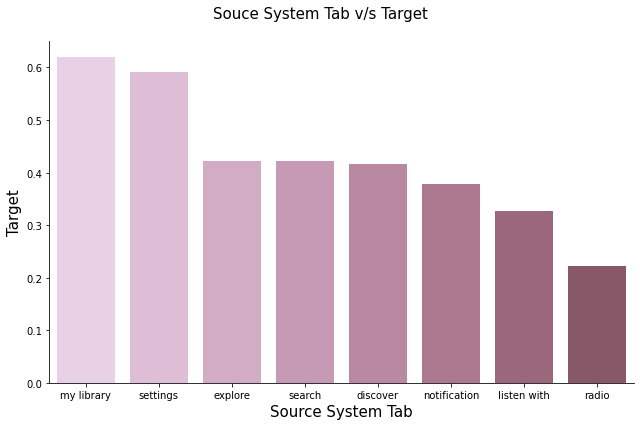

In [10]:
repeat_df.reset_index(level = 0,inplace = True)
repeat_df.columns = ['Source System Tab', 'Target']
plt.rcParams['axes.labelsize'] = 15
ax = sns.catplot(x = 'Source System Tab', y = 'Target', kind = 'bar',
               palette = 'ch:7,-.2,dark = .4', data =  repeat_df,
               height = 6, aspect = 1.5)
ax.fig.subplots_adjust(top = .9)
ax.fig.suptitle('Souce System Tab v/s Target', fontsize = 15)
plt.show()


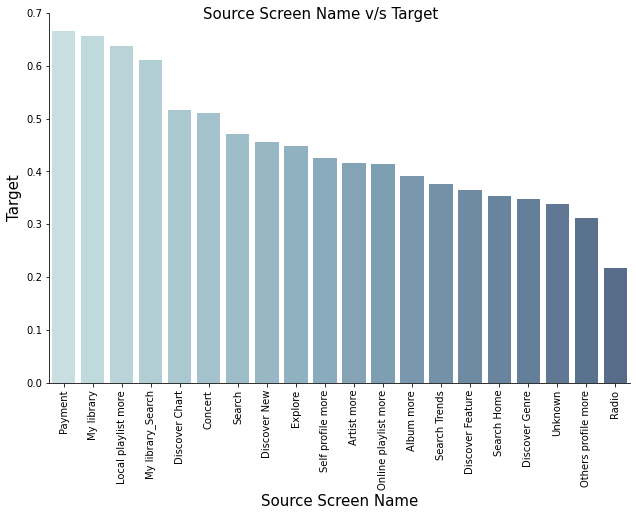

In [11]:
name = train.groupby(['source_screen_name']).mean(
).sort_values(by = 'target', ascending = False)
name.reset_index(level = 0, inplace = True)
name.columns = ['Source Screen Name', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x = 'Source Screen Name', y = 'Target', kind = 'bar',
                palette = 'ch:12,-.2, dark = .4', data = name,
                height = 6, aspect = 1.5)
ax.fig.suptitle('Source Screen Name v/s Target', fontsize = 15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation = 90)

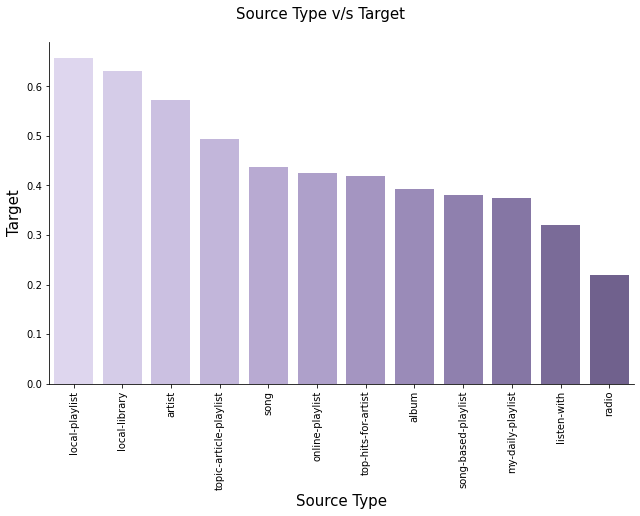

In [12]:
Type = train.groupby(['source_type']).mean().sort_values(by = 'target', 
            ascending = False)
Type.reset_index(level = 0, inplace = True)
Type.columns = ['Source Type', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x = 'Source Type', y = 'Target', kind = 'bar',
                palette = 'ch:.12,0,dark=.4', data = Type, height = 6,
                aspect = 1.5)
ax.fig.subplots_adjust(top = .9)
ax.fig.suptitle('Source Type v/s Target', fontsize = 15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation = 90)

**1.4 let us find the song repeat counts and find most popular songs**

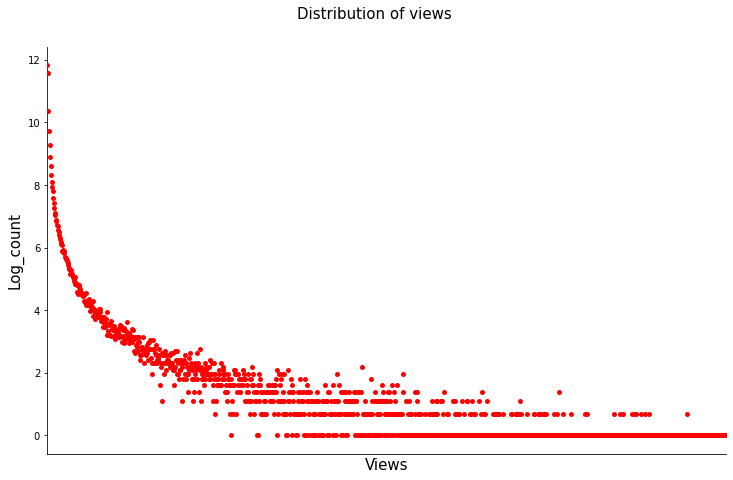

In [13]:
Type = train.groupby(['song_id']).sum().sort_values(by = 'target',
                                ascending =  False)
Type.reset_index(level = 0, inplace = True)
Type.columns = ['Source Type', 'Views']
new = Type.groupby(['Views']).count()
new.reset_index(inplace = True)
new.columns = ['Views', 'Log_count']
new['Log_count'] = np.log(new.Log_count)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x = 'Views', y = 'Log_count', kind = 'strip',
                color = 'red', height = 7, aspect = 1.5, data = new)
ax.fig.subplots_adjust(top = .9)
ax.fig.suptitle('Distribution of views', fontsize = 15)
ax.set(xticks=[])
plt.show()

### 2. Songs Data Exploration

In [14]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


**2.1 let us check if we have missing values**

In [15]:
songs.isnull().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

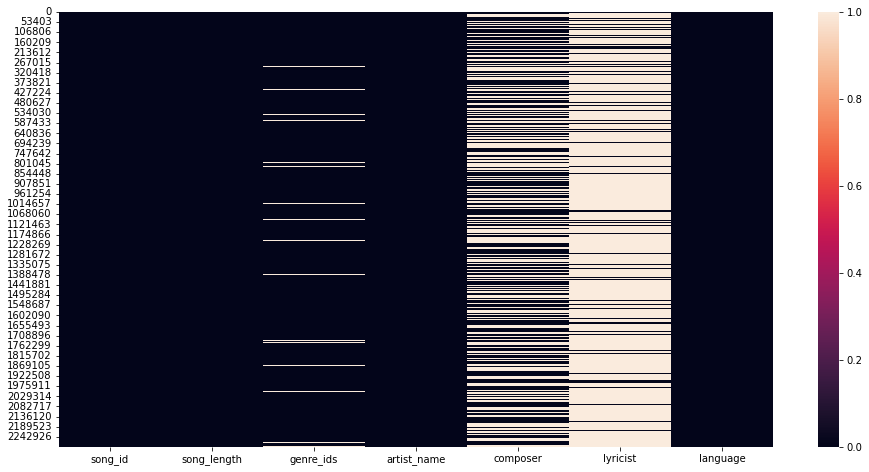

In [16]:
plt.figure(figsize = (16,8))
sns.heatmap(songs.isnull())
plt.show()

**2.2 let us check distribution of language**

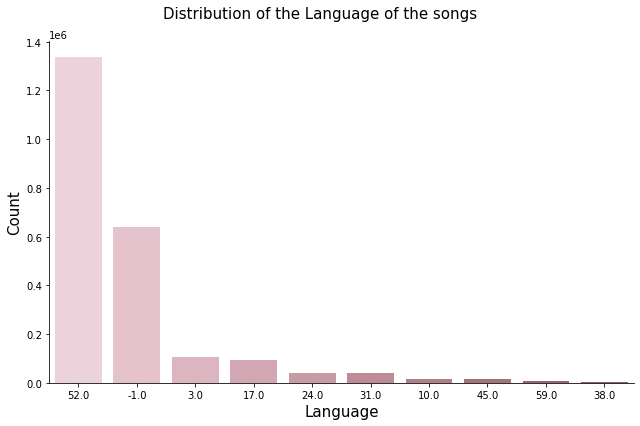

In [17]:
language = songs.groupby(['language']).size()
language = pd.DataFrame(language)
language.reset_index(level = 0, inplace = True)
language.columns = ['Language' , 'Count']
language = language.sort_values(by='Count',ascending = False)
language['Language'] = language['Language'].astype('str')
ax = sns.catplot(x='Language', y='Count', kind='bar',
                 order=language['Language'],palette="ch:10,-0.1,dark=.4",
                 data=language, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of the Language of the songs', fontsize = 15)
plt.show()

**2.3 let us check distribution of song length**

count    2.296320e+06
mean     4.116558e+00
std      2.682000e+00
min      3.083333e-03
25%      3.060000e+00
50%      3.777117e+00
75%      4.621150e+00
max      2.028975e+02
Name: song_length, dtype: float64


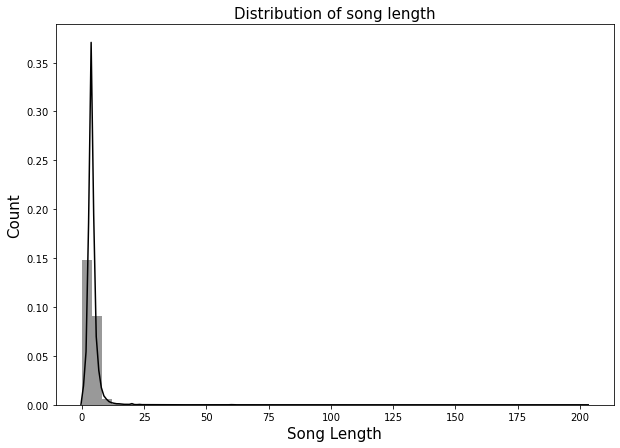

In [21]:
print((songs.song_length/60000).describe())
plt.subplots(figsize = (10,7))
x = songs.song_length/60000
ax = sns.distplot(x, color = 'black')
ax.set_title("Distribution of song length", fontsize = 15)
ax.set(xlabel = "Song Length", ylabel = "Count")
plt.show()

### 3. Extra Song Data Exploration

In [41]:
extra_song.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


**3.1 Let us check if we have any missing values**

In [42]:
extra_song.isnull().sum()

song_id         0
name            2
isrc       136548
dtype: int64

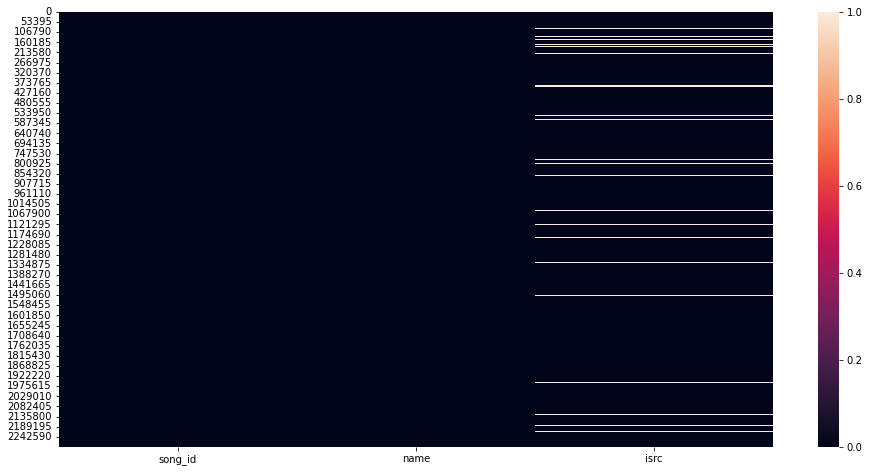

In [43]:
plt.figure(figsize = (16,8))
sns.heatmap(extra_song.isnull())
plt.show()

## **Data Preparation**

In [61]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [62]:
dataframe = train.sample(frac = 0.01)

In [63]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


**Joining songs and train datasets**

In [64]:
dataframe = pd.merge(dataframe, songs, on = 'song_id', how = 'left')
del songs

In [65]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msno                73774 non-null  object 
 1   song_id             73774 non-null  object 
 2   source_system_tab   73515 non-null  object 
 3   source_screen_name  69589 non-null  object 
 4   source_type         73561 non-null  object 
 5   target              73774 non-null  int64  
 6   song_length         73773 non-null  float64
 7   genre_ids           72633 non-null  object 
 8   artist_name         73773 non-null  object 
 9   composer            57209 non-null  object 
 10  lyricist            42210 non-null  object 
 11  language            73773 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 7.3+ MB


**Checking Null**

In [66]:
dataframe.isnull().sum()/dataframe.isnull().count()*100

msno                   0.000000
song_id                0.000000
source_system_tab      0.351072
source_screen_name     5.672730
source_type            0.288720
target                 0.000000
song_length            0.001355
genre_ids              1.546615
artist_name            0.001355
composer              22.453710
lyricist              42.784721
language               0.001355
dtype: float64

**Replace NA**

In [67]:
for i in dataframe.select_dtypes(include = ['object']).columns:
    dataframe[i][dataframe[i].isnull()] = 'unknown'
dataframe = dataframe.fillna(value = 0)

**Object data to category**

In [68]:
for col in dataframe.select_dtypes(['object']).columns:
    dataframe[col] = dataframe[col].astype('category')

**Encoding categorical features**

In [69]:
for col in dataframe.select_dtypes(['category']).columns:
    dataframe[col] = dataframe[col].cat.codes

## **Correlation Matrix**

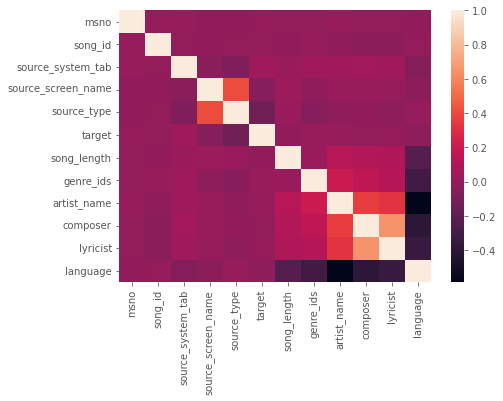

In [70]:
plt.figure(figsize=[7,5])
sns.heatmap(dataframe.corr())
plt.show()

# **Random Forest**

In [71]:
model =  ensemble.RandomForestClassifier(n_estimators = 250,
                                         max_depth = 25)
model.fit(dataframe[dataframe.columns[dataframe.columns != 'target']],
         dataframe['target'])

RandomForestClassifier(max_depth=25, n_estimators=250)

In [72]:
df_plot = pd.DataFrame({'Features' : dataframe.columns[dataframe.columns != 'target'],
                       'Importance' : model.feature_importances_})
df_plot = df_plot.sort_values('Importance', ascending = False)

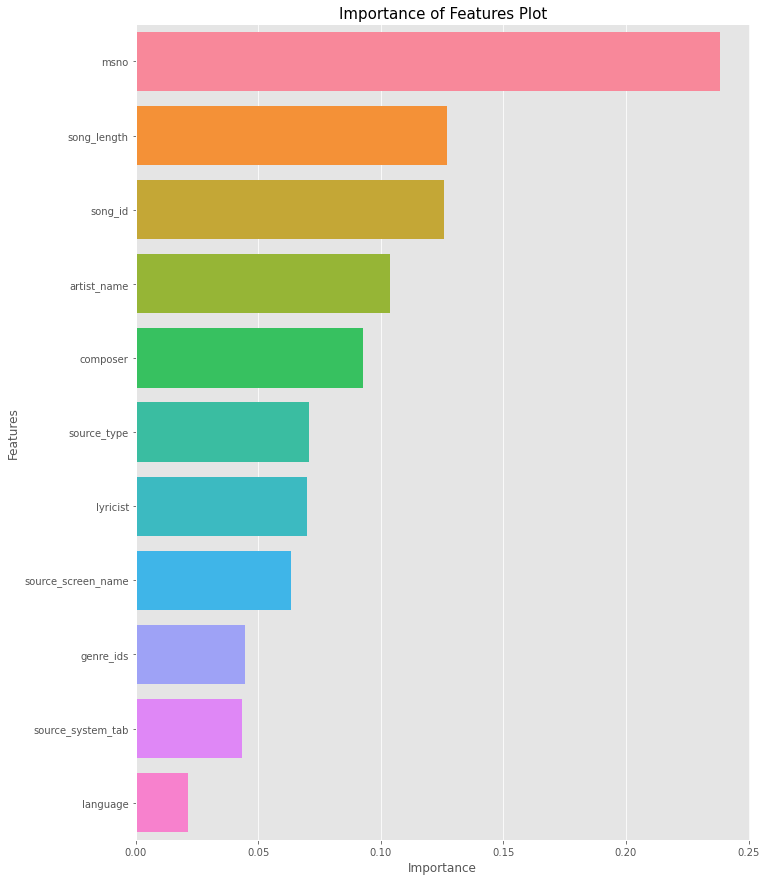

In [85]:
plt.figure(figsize = [11,15])
sns.barplot(x = df_plot.Importance, y = df_plot.Features,saturation=10)
plt.title("Importance of Features Plot", fontsize = 15)
plt.show()

**Drop columns with importance < 0.04**

In [92]:
dataframe = dataframe.drop(df_plot.Features[df_plot.Importance < 0.04].tolist(),1)

In [93]:
dataframe.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist'],
      dtype='object')

# **XGboost**

**train and test split**

In [94]:
target = dataframe.pop('target')
X_train , X_test, y_train, y_test = train_test_split(dataframe, target,
                                                    test_size = 0.3)

In [136]:
model2 = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 15,min_child_weight = 4, 
                           n_estimators =  30)
model2.fit(X_train,y_train)

[00:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=15, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:
pred = model2.predict(X_test)

In [138]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61     10900
           1       0.62      0.66      0.64     11233

    accuracy                           0.63     22133
   macro avg       0.63      0.63      0.62     22133
weighted avg       0.63      0.63      0.63     22133

